In [ ]:
# Instalamos split-folders para la partición de imagenes en train-val-test
!pip install split-folders

# Instalamos Keras Tuner
!pip install -q -U keras-tuner

# Imports

In [ ]:
# Imports
from google.colab import files # para abrir Kaggle API Token
import os, random
import numpy as np
import cv2
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory, array_to_img, load_img, img_to_array
from keras import Sequential
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Hiperparametros
A lo largo de todo el proyecto, trabajaremos con los siguientes hiperparametros:

In [ ]:
batch_size = 32
epochs = 30

# Funciones auxiliares

In [ ]:
# Definimos la función para visualizar las curvas de pérdidas y de la métrica seleccionada
def create_charts(H):
  fig, axs = plt.subplots(1,2, figsize=(20,3))
  
  # Dibujamos las curvas de Loss
  axs[0].plot(range(1,epochs+1), H.history['loss'], label='Train')
  axs[0].plot(range(1,epochs+1), H.history['val_loss'], label='Val')
  axs[0].set_title('Loss')  
  
  # Dibujamos las curvas de Accuracy
  axs[1].plot(range(1,epochs+1), H.history['accuracy'], label='Train')
  axs[1].plot(range(1,epochs+1), H.history['val_accuracy'], label='Val')  
  axs[1].set_title('Accuracy')

  # Personalizamos las gráficas
  for ax in axs:
    ax.set_xlabel('Epoch')
    ax.set_xticks(range(1,epochs+1)) # range(1,epochs+1,10) para etiquetas eje X de 10 en 10
    ax.set_ylim([0, 1])
    ax.legend()

  plt.show()


# Definimos la función para realizar la extracción de las predicciones
def extraer_predicciones(model, test):
  proba = [] # Predicciones con probabilidad por clase
  y_pred = [] # Predicciones convertidas de probabilidad a etiqueta
  y_test = [] # Etiquetas verdaderas

  for images, labels in test:
    proba.append(model.predict(images,verbose=0))
    y_test.extend(labels.numpy().tolist())

  # Convertimos probabilidades a etiquetas
  for batch in proba:
    # Para cada predicción dentro del batch
    for prediccion in batch:
      y_pred.append(np.argmax(prediccion))

  return y_test, y_pred


# Definimos la función para visualizar los resultados de evaluación sobre Test
# utilizando Classification Report y Confusion Matrix
def ver_resultados(y_test, y_pred):
  print('Classification report:', end='\n\n')
  print(classification_report(y_test, y_pred), end='\n\n')
  
  print('Confusion Matrix:', end='\n\n')
  plt.figure(figsize=(2,2))
  cm=confusion_matrix(y_test, y_pred)
  sns.heatmap(cm,annot=True,fmt='d')
  plt.show()

# Introducción


El dataset asignado consta de 15.000 imágenes, repartidas por igual entre 3 clases: Bota, Zapato y Sandalia.

Link al dataset: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

Las imágenes tienen una resolucion de 136x102 pixeles en color RGB (3 canales).

El proyecto se divide en dos estrategias:

**Estrategia 1:** Entrenamiento from scratch

1. Realizamos la carga y visualización de los datos para poder abordar el trabajo con conocimiento.
2. Mostramos los resultados obtenidos con la primeras pruebas de arquitecturas para diseñar el modelo final.
3. Entrenamos el modelo con la arquitectura elegida, observamos que produce overfitting.
3. Sobre la arquitectura elegida realizamos entrenamientos con regularización y con Data Augmentation para solventar el problema de overfitting obtenido.
4. Valoramos que método nos proporciona mejores resultados, **Regularizacion vs Data Augmentation.**
5. Con la ayuda de KerasTuner, encontramos los valores de los hiperparametros que mejor se adapten a nuestro modelo.



**Estrategia 2:** Red pre-entrenada

1. Elegimos dos redes pre-entrenadas: Resnet50 y MobilenetV2, para entrenar nuestro dataset.
2. Entrenamos cada una de ellas por separado con la arquitectura definitiva del modelo obtenida en la *Estrategia 1*.
3. Comparamos los resultados obtenidos y elegimos la que mejor se adapte a nuestro objetivo.


En el apartado **CONCLUSIONES** se realizará una comparación del modelo "from scratch" con el mejor modelo de la red pre-entrenada.

# Model From Scratch
A continuación vamos a diseñar el modelo desde cero.

## Carga y visualización de datos

In [ ]:
# Cargamos el API Token personal de Kaggle (fichero kaggle.json)
# Se omite el output para no revelar la key personal del usuario
files.upload()

In [ ]:
%%capture
# Copiamos el fichero de Token en la ubicación requerida por la API
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargamos el dataset a través de API de Kaggle
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
# Creamos un directorio para descomprimir los datos
!mkdir my_dataset

# Descomprimimos el dataset
!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d my_dataset
# Guardamos la ruta del dataset en una variable
carpeta = 'my_dataset/Shoe vs Sandal vs Boot Dataset/'

#Realizamos la partición de datos en train-val-test con splitflorders
#Los archivos se barajan y una semilla hace que las divisiones sean reproducibles.
input_folder = carpeta
output_folder = 'my_dataset'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

# Guardamos el tamaño de la imagen en una variable
img = cv2.imread(carpeta + 'Boot/boot (3).jpg', cv2.COLOR_BGR2RGB)
image_shape = img.shape

In [ ]:
# Cargamos los datos
train = image_dataset_from_directory('my_dataset/train',
                                     labels='inferred',
                                     label_mode='int',
                                     batch_size=batch_size,
                                     image_size=image_shape[:2])

val = image_dataset_from_directory('my_dataset/val',
                                   labels='inferred',
                                   label_mode='int',
                                   batch_size=batch_size,
                                   image_size=image_shape[:2])

test = image_dataset_from_directory('my_dataset/test',
                                    labels='inferred',
                                    label_mode='int',
                                    batch_size=batch_size,
                                    image_size=image_shape[:2])

Found 12000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [ ]:
# Exploramos las clases disponibles
clases = train.class_names
print(clases)

['Boot', 'Sandal', 'Shoe']


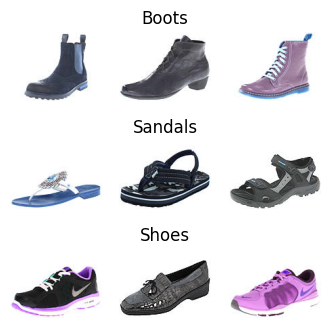

In [ ]:
#Visualización del dataset por clases
imagenes = []
for clase in clases:
    for i in range(3):
    fichero = random.choice(os.listdir(carpeta+clase))
    imagen = cv2.imread(carpeta + clase + '/' + fichero, cv2.COLOR_BGR2RGB)
    imagenes.append(imagen)

fig = plt.figure(figsize=(4,4))
for n in range(1,10):
    fig.add_subplot(3, 3, n)
    img = imagenes[n-1]
    plt.imshow(img)
    if n%3-2==0: plt.title(clases[(n-1)//3]+'s')
    plt.axis('off')

Tras relizar una pequeña inspección visual de las imágenes, observamos que todas ellas están perfectamente encuadradas y tienen una buena definición, para cada clase existen imágenes de modelos distintos, se incluyen modelos tanto masculinos como femeninos, modelos deportivos, de montaña y de vestir. 

Concluimos que nos encontramos ante un dataset con gran variabilidad dentro de sus clases, esto nos favorece a la hora de entrenarlo.

## Tabla-resumen de las estructuras probadas

Debido a la simplicidad del dataset, rápidamente conseguimos dar con una arquitectura de partida que presentaba muy buenos resultados. Hemos probado aumentar su complejidad, pero los resultados fueron empeorando. Por ello nos hemos centrado en ir realizando pequeñas modificaciones a la primera arquitectura que se muestra en la tabla más abajo.

Todas ellas han sido entrenadas en 30 epocas con los datos de train y validation, utilizando el optimizador de keras *Adam* y la función de perdidas *SparseCategoricalCrossentropy* la cual nos permite trabajar con múltiples clases sin tener que convertir a One-Hot Encoding.

En todas las arquitecturas, el base model consiste de 2 bloques convolucionales, cada uno de 2 capas convolucionales con 16 y 32 filtros de tamaño 3x3 y padding, seguidos de MaxPooling de 2x2.<br><br>

|Top Model|Parámetros entrenables|Accuracy|
|------|----------------|--------|
|**Flatten + 3 Dense**  |440,467| **0.96**|
|Flatten +5 Dense + Dropout(0.75) | 1,312,995 | **0.66** |
|Flatten +3 Dense + Dropout(0.5) | 440,467 | **0.96**|
|**Flatten +3 Dense + Dropout(0.5)+BatchNorm** | 440,499 | **0.97**|        

<br>

Si realizamos un pequeño análisis de los resultados, podemos observar a simple vista que la primera arquitectura, la cual no incluye ningún tipo de regularización, genera muy buenos resultados (accuracy: 96%), el modelo es capaz de predecir correctamente las clases de nuestro dataset durante la fase de entrenamiento, sin embargo, durante la fase de validación se produce overfitting, el modelo esta sobreajustado, realiza las prediciones de memoria. Mostraremos su entrenamiento más adelante.

Para reducir el overfitting se llevan a cabo las siguientes pruebas de arquitecturas y se obtienen los resultados que figuran en la tabla, como era de esperar al incorporar regularización de tipo dropout con un valor de 0.75, el resultado que obtenemos es muy bajo, se pierden demasiadas conexiones entre neuronas, se reduce el overfitting pero se pierde bastante valor de accuracy, en la siguiente estructura se prueba un dropout con un valor menor y se obtienen el mismo accuracy que al principio, podríamos utilizar esta arquitectura como la final para entrenar el modelo, pero vamos un paso más alla y tras realizar diferentes entrenamientos posteriores, decidimos seleccionar la última arquitectura, la cual incluye BatchNormalization y nos da como resultado de accuracy un valor de 0.97, aumentando una décima el valor inicial respecto a la primera arquitectura que producía overfitting.

Es por ello por lo que escogemos la última arquitectura como candidata para entrenar nuestro modelo final.


## Entrenamiento del modelo antes de la regularización

In [ ]:
# ARQUITECTURA 1: PRESENTA OVERFITTING 
def create_model_1():
  model = Sequential()
  model.add(layers.Rescaling(1./255)) # Normalizamos los inputs al rango [0,1] para facilitar la convergencia

  # Bloque 1
  model.add(layers.Conv2D(filters=16, kernel_size=(3,3), input_shape=image_shape,
                          activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))

  # Bloque 2
  model.add(layers.Conv2D(filters=32, kernel_size=(3,3),
                          activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))

  # Top Model:
  model.add(layers.Flatten())
  model.add(layers.Dense(units=16, activation='relu'))
  model.add(layers.Dense(units=8, activation='relu'))
  model.add(layers.Dense(units=3, activation='softmax'))

  return model

In [ ]:
model= create_model_1()
model.compile(optimizer= 'adam', loss= 'SparseCategoricalCrossentropy', metrics=['accuracy'])
model.build(input_shape=(batch_size,)+image_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 102, 136, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 102, 136, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 51, 68, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 51, 68, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 25, 34, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (32, 27200)               0

In [ ]:
# Realizamos el entrenamiento
history= model.fit(train, validation_data=val, epochs=epochs)

Epoch 1/30
375/375 [==============================] - 17s 15ms/step - loss: 0.5962 - accuracy: 0.7184 - val_loss: 0.4071 - val_accuracy: 0.8507
Epoch 2/30
375/375 [==============================] - 6s 15ms/step - loss: 0.3494 - accuracy: 0.8668 - val_loss: 0.3117 - val_accuracy: 0.8980
Epoch 3/30
375/375 [==============================] - 6s 17ms/step - loss: 0.2457 - accuracy: 0.9132 - val_loss: 0.2321 - val_accuracy: 0.9273
Epoch 4/30
375/375 [==============================] - 6s 16ms/step - loss: 0.1846 - accuracy: 0.9359 - val_loss: 0.2213 - val_accuracy: 0.9293
Epoch 5/30
375/375 [==============================] - 9s 23ms/step - loss: 0.1471 - accuracy: 0.9471 - val_loss: 0.1800 - val_accuracy: 0.9433
Epoch 6/30
375/375 [==============================] - 5s 14ms/step - loss: 0.1144 - accuracy: 0.9622 - val_loss: 0.1579 - val_accuracy: 0.9533
Epoch 7/30
375/375 [==============================] - 6s 17ms/step - loss: 0.0948 - accuracy: 0.9687 - val_loss: 0.2343 - val_accuracy: 0.919

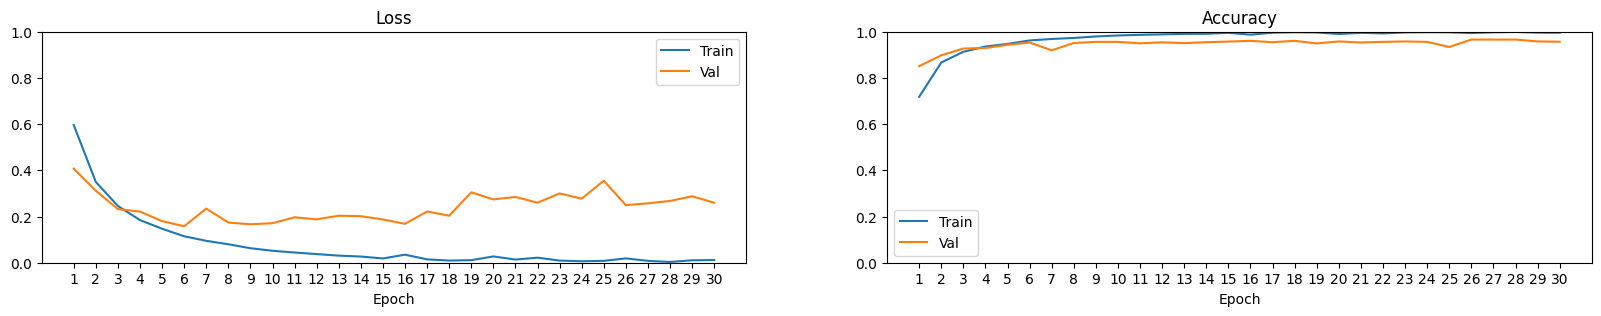

In [ ]:
#Visualizamos las curvas de pérdidas y de la métrica seleccionada
create_charts(history)

Como habíamos mencionado anteriormente, la primera arquitectura propuesta sin regularización produce overfitting .

Classification report:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       500
           1       0.98      0.94      0.96       500
           2       0.94      0.94      0.94       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500


Confusion Matrix:



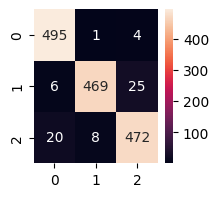

In [ ]:
# Evaluación del modelo sobre Test
y_test, y_pred = extraer_predicciones(model, test)
ver_resultados(y_test, y_pred)

## Data Augmentation
En esta sección aplicaremos la técnica de Data Augmentation para eliminar o reducir el overfitting que presenta nuestro modelo. Posteriormente evaluaremos el rendimiento del modelo sobre el conjunto del test para luego comparar los resultados con el modelo regularizado utilizando otras técnicas.

Como habíamos observado en la parte de exploración de los datos, todas las imagenes son bastante perfectas. Por ello, nuestro generador para train hará pocas modificaciones a las imágenes, ya que alterándolas demasiado puede perjudicar su rendimiento en val y sobre todo en test.

In [ ]:
# Creamos los ImageDataGenerators

datagen_train=ImageDataGenerator(rotation_range=10,
                                 zoom_range=0.1)

train_set = datagen_train.flow_from_directory(directory='my_dataset/train',
                                              target_size=image_shape[:2],
                                              color_mode="rgb",
                                              batch_size= batch_size,
                                              class_mode="sparse",
                                              shuffle=True,
                                              seed=42)

# Generador para Validation y Test, sin aplicar ninguna modificación de imagen
datagen=ImageDataGenerator()

val_set = datagen.flow_from_directory(directory='my_dataset/val',
                                      target_size=image_shape[:2],
                                      color_mode="rgb",
                                      batch_size= batch_size,
                                      class_mode="sparse",
                                      shuffle=True,
                                      seed=42)

test_set = datagen.flow_from_directory(directory='my_dataset/test',
                                      target_size=image_shape[:2],
                                      color_mode="rgb",
                                      batch_size= batch_size,
                                      class_mode="sparse",
                                      shuffle=True,
                                      seed=42)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


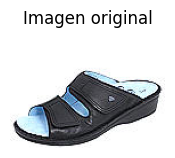

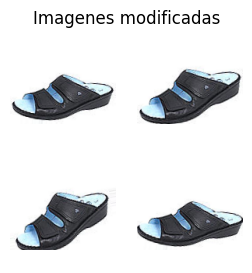

In [ ]:
# Visualizamos una imagen modificada por el generador de train

# Cargamos una imagen original aleatoria
plt.figure(figsize=(2,2))
clase = random.choice(os.listdir(carpeta))
fichero = random.choice(os.listdir(carpeta+clase))
imagen = cv2.imread(carpeta + clase + '/' + fichero, cv2.COLOR_BGR2RGB)
plt.imshow(imagen)
plt.title('Imagen original')
plt.axis('off')

# Pasamos la imagen por el generador
img = imagen.reshape((1,)+imagen.shape)
batch1 = datagen_train.flow(img, batch_size=1)
fig = plt.figure(figsize=(3,3))
plt.title('Imagenes modificadas')
plt.axis('off')
for n in range(1,5):
    fig.add_subplot(2, 2, n)
    img = batch1[0][0].astype('uint8')
    plt.imshow(array_to_img(img))
    plt.axis('off')

plt.show()

In [ ]:
# Creamos el modelo utilizando la arquitectura que presenta overfitting
model_aug = create_model_1()
model_aug.compile(optimizer= 'adam', loss= 'SparseCategoricalCrossentropy', metrics=['accuracy'])
model_aug.build(input_shape=(batch_size,)+image_shape)

In [ ]:
# Entrenamos el modelo
step_size_train = train_set.n//train_set.batch_size
step_size_val = val_set.n//val_set.batch_size

H_aug = model_aug.fit(train_set,
                      steps_per_epoch = step_size_train,
                      validation_data = val_set,
                      validation_steps = step_size_val,
                      epochs=epochs)

Epoch 1/30
375/375 [==============================] - 63s 123ms/step - loss: 0.6330 - accuracy: 0.7410 - val_loss: 0.2981 - val_accuracy: 0.8906
Epoch 2/30
375/375 [==============================] - 48s 127ms/step - loss: 0.2702 - accuracy: 0.8988 - val_loss: 0.1867 - val_accuracy: 0.9348
Epoch 3/30
375/375 [==============================] - 46s 123ms/step - loss: 0.2127 - accuracy: 0.9221 - val_loss: 0.1493 - val_accuracy: 0.9511
Epoch 4/30
375/375 [==============================] - 46s 123ms/step - loss: 0.1842 - accuracy: 0.9327 - val_loss: 0.1386 - val_accuracy: 0.9538
Epoch 5/30
375/375 [==============================] - 46s 122ms/step - loss: 0.1732 - accuracy: 0.9374 - val_loss: 0.1413 - val_accuracy: 0.9524
Epoch 6/30
375/375 [==============================] - 46s 122ms/step - loss: 0.1546 - accuracy: 0.9452 - val_loss: 0.1329 - val_accuracy: 0.9518
Epoch 7/30
375/375 [==============================] - 46s 123ms/step - loss: 0.1367 - accuracy: 0.9531 - val_loss: 0.1343 - val_ac

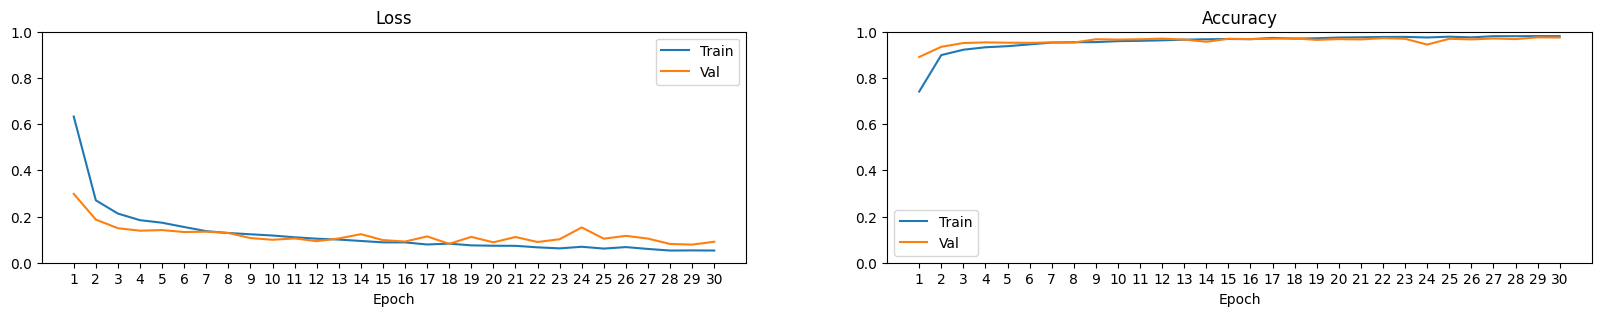

In [ ]:
create_charts(H_aug)

Observamos que Data Augmentation elimina overfitting. Ahora queda evaluar sobre el conjunto de Test y comparar los resultados con otros métodos de regularización.

In [ ]:
# Evaluación sobre Test

# No se utiliza la función extraer_predicciones debido a que
# interactuamos con ImageDataGenerator utilizando .next()

# Extraemos imágenes y sus etiquetas del generador de Test
proba = [] # Predicciones con probabilidad por clase
y_pred = [] # Predicciones convertidas de probabilidad a etiqueta
y_test = [] # Etiquetas verdaderas

for i in range(test_set.n//batch_size+1):
  images, labels = test_set.next()
  proba.append(model_aug.predict(images,verbose=0))
  y_test.extend(labels.tolist())

# Convertimos probabilidades a etiquetas
for batch in proba:
  # Para cada predicción dentro del batch
  for prediccion in batch:
    y_pred.append(np.argmax(prediccion))

Classification report:

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       504
         1.0       0.98      0.97      0.97       507
         2.0       0.98      0.97      0.97       489

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500


Confusion Matrix:



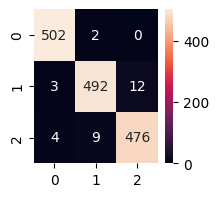

In [ ]:
# Visualizamos los resultados
ver_resultados(y_test, y_pred)

## Regularización
Inicialmente hemos incluido BatchNormalization tras cada una de las capas densas ocultas, seguido de Dropout. Los resultados no fueron satisfactorios, entonces a base de realizar pruebas hemos llegado a la configuración de la regularización que se implementa en la siguiente celda, que fue la que mejores resultados ha presentado.

In [ ]:
#ARQUITECTURA 2: REGULARIZACION 
def create_model_2(): 
  model = Sequential()
  model.add(layers.Rescaling(1./255)) # Normalizamos los inputs al rango [0,1] para facilitar la convergencia

  # Bloque 1
  model.add(layers.Conv2D(filters=16, kernel_size=(3,3), input_shape=image_shape,
                          activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))

  # Bloque 2
  model.add(layers.Conv2D(filters=32, kernel_size=(3,3),
                          activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))

  # Top Model
  model.add(layers.Flatten())
  model.add(layers.Dense(units=16,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(units=8,activation='relu'))
  model.add(layers.Dense(units=3, activation='softmax'))

  return model

In [ ]:
model=create_model_2()
model.compile(optimizer= 'adam', loss= 'SparseCategoricalCrossentropy', metrics=['accuracy'])
model.build(input_shape=(batch_size,)+image_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (32, 102, 136, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (32, 102, 136, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (32, 51, 68, 16)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (32, 51, 68, 32)          4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 25, 34, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (32, 27200)              

In [ ]:
# Realizamos el entrenamiento
history = model.fit(train, validation_data=val, epochs=epochs)

Epoch 1/30
375/375 [==============================] - 9s 16ms/step - loss: 0.9712 - accuracy: 0.5295 - val_loss: 0.7469 - val_accuracy: 0.8607
Epoch 2/30
375/375 [==============================] - 6s 17ms/step - loss: 0.8187 - accuracy: 0.6239 - val_loss: 0.6953 - val_accuracy: 0.8087
Epoch 3/30
375/375 [==============================] - 6s 16ms/step - loss: 0.7705 - accuracy: 0.6482 - val_loss: 0.5604 - val_accuracy: 0.9007
Epoch 4/30
375/375 [==============================] - 7s 19ms/step - loss: 0.7414 - accuracy: 0.6859 - val_loss: 0.6396 - val_accuracy: 0.7867
Epoch 5/30
375/375 [==============================] - 7s 19ms/step - loss: 0.7074 - accuracy: 0.7094 - val_loss: 0.5504 - val_accuracy: 0.7867
Epoch 6/30
375/375 [==============================] - 6s 15ms/step - loss: 0.4890 - accuracy: 0.8099 - val_loss: 0.3051 - val_accuracy: 0.9153
Epoch 7/30
375/375 [==============================] - 6s 16ms/step - loss: 0.3932 - accuracy: 0.8540 - val_loss: 0.2403 - val_accuracy: 0.9253

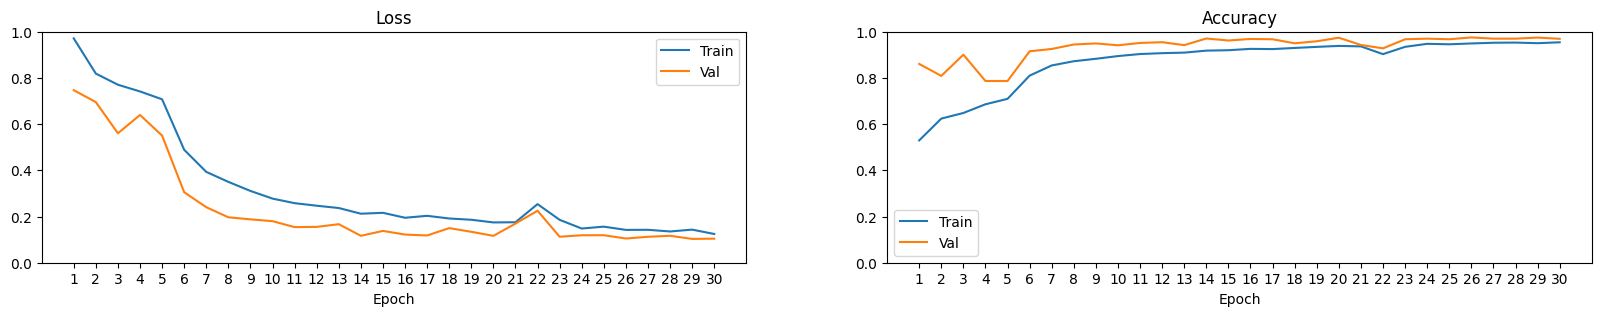

In [ ]:
# Visualizamos las curvas de pérdidas y de la métrica seleccionada
create_charts(history)

Classification report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.99      0.93      0.96       500
           2       0.95      0.98      0.97       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500


Confusion Matrix:



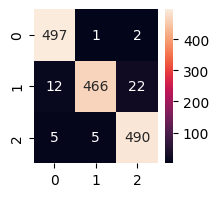

In [ ]:
#Evaluación del modelo sobre Test
y_test, y_pred = extraer_predicciones(model, test)
ver_resultados(y_test, y_pred)

Se observa que el modelo no presenta overffiting.

## Data Augmentation vs Regularización
Concluimos que Data Augmentation ofrece mejores resultados en nuestro modelo, se consigue un accuracy del 0.98 (aumentamos una decima el valor obtenido anteriormente) y además, observamos que las curvas de perdida del modelo entrenado con regularización, a partir de la epoca 30 se estancan, el modelo no es capaz de seguir aprendiendo.

Hemos realizado entrenamientos aumentando el número de epocas (epochs=60) para ver como se comportaba el modelo y verificamos el estancamiento de este.

## Keras Tuner

Definimos una función que define la topología de red y compila el modelo. Buscamos el número de filtros óptimo para las capas convolucionales. También vamos a buscar el valor óptimo de unidades en la primera y segunda capa densa.

In [ ]:
def model_builder(hp):
  model_tuner = Sequential()
  model_tuner.add(layers.Rescaling(1./255))

  # Bloque 1
  filters_1 = hp.Int('filters_1',min_value = 32,max_value = 128, step=32)
  model_tuner.add(layers.Conv2D(filters_1, kernel_size=(3,3), input_shape=image_shape,
                                activation='relu', padding='same'))
  model_tuner.add(layers.MaxPool2D(pool_size=(2,2)))

  # Bloque 2
  filters_2 = hp.Int('filters_2',min_value = 64,max_value = 128, step=32)
  model_tuner.add(layers.Conv2D(filters_2, kernel_size=(3,3),
                                activation='relu', padding='same'))
  model_tuner.add(layers.MaxPool2D(pool_size=(2,2)))

  #Top Model
  model_tuner.add(layers.Flatten())
  
  hp_units_1 = hp.Int('units_1', min_value = 16, max_value = 32, step = 16)
  model_tuner.add(layers.Dense(units=hp_units_1,activation='relu'))
  model_tuner.add(layers.Dropout(0.5))
  model_tuner.add(BatchNormalization())

  hp_units_2 = hp.Int('units_2', min_value = 8, max_value = 16, step = 8)
  model_tuner.add(layers.Dense(units=hp_units_2,activation='relu'))
  model_tuner.add(layers.Dense(units=3, activation='softmax'))

  model_tuner.compile(optimizer= 'adam', loss= 'SparseCategoricalCrossentropy', metrics=['accuracy'])
  
  return model_tuner

In [ ]:
# Instanciamos el objeto optimizador
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt',
                     overwrite=True)  

In [ ]:
# Llevamos a cabo la optimización de hiperparámetros y nos quedamos con el mejor resultado

#https://blog.paperspace.com/hyperparameter-optimization-with-keras-tuner/
tuner.search(train, epochs = 10, validation_data = val, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

# Ejecutamos el Tuner para obtener los mejores hiperparametros
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in first convolutional layer is {best_hps.get('filters_1')} and in the second convolutional layer is {best_hps.get('filters_2')}. The optimal number of units in first dense layer is {best_hps.get('units_1')} and in second dense layer is {best_hps.get('units_2')}.
""")

Trial 30 Complete [00h 01m 06s]
val_accuracy: 0.9633333086967468

Best val_accuracy So Far: 0.9700000286102295
Total elapsed time: 00h 14m 15s

The hyperparameter search is complete. The optimal number of filters is 32 and 64. The optimal number of units is 32 and 16.

32
64
32
16


In [ ]:
# Construcción del modelo con los mejores valores para los hiperparámetros calculados y entrenamiento del modelo
modelKT = tuner.hypermodel.build(best_hps)
modelKT.fit(train, 
          validation_data= (val), 
          epochs= 30,
           callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/30
375/375 [==============================] - 9s 19ms/step - loss: 0.7836 - accuracy: 0.6280 - val_loss: 0.5367 - val_accuracy: 0.7900
Epoch 2/30
375/375 [==============================] - 7s 18ms/step - loss: 0.4978 - accuracy: 0.7922 - val_loss: 0.2770 - val_accuracy: 0.9207
Epoch 3/30
375/375 [==============================] - 7s 18ms/step - loss: 0.4316 - accuracy: 0.8232 - val_loss: 0.3048 - val_accuracy: 0.9053
Epoch 4/30
375/375 [==============================] - 6s 15ms/step - loss: 0.4047 - accuracy: 0.8216 - val_loss: 0.1765 - val_accuracy: 0.9500
Epoch 5/30
375/375 [==============================] - 6s 15ms/step - loss: 0.3440 - accuracy: 0.8507 - val_loss: 0.1550 - val_accuracy: 0.9413
Epoch 6/30
375/375 [==============================] - 7s 18ms/step - loss: 0.3140 - accuracy: 0.8684 - val_loss: 0.1400 - val_accuracy: 0.9627
Epoch 7/30
375/375 [==============================] - 6s 15ms/step - loss: 0.2669 - accuracy: 0.8873 - val_loss: 0.1225 - val_accuracy: 0.9667

In [ ]:
# Evaluación de resultados 
eval_result = modelKT.evaluate(test)
print(f"test loss: {eval_result[0]}, test accuracy: {eval_result[1]}")

47/47 [==============================] - 2s 34ms/step - loss: 0.1265 - accuracy: 0.9627
test loss: 0.12654916942119598, test accuracy: 0.9626666903495789


## Conclusiones modelo desde cero
Observamos que de todas las técnicas aplicadas para reducir overfitting y encontrar una mejor combinación de parámetros, los mejores resultados obtenidos fueron con Data Augmentation, presentando un 98% de accuracy sobre el Test set.

# Transfer Learning

En este apartado nos limitaremos a realizar Transfer Learning reemplazando el Top Model por el diseñado en el apartado anterior. Mantenemos todas las capas del Base Model congeladas, ya que consideramos que el dominio de nuestro dataset es muy cercano al dominio de ImageNet. Tal y como veremos a continuación, esta configuración presentará unos resultados superiores al 99% de accuracy sobre el Test set.

Para llevar a cabo las tareas de Transfer Learning utilizaremos 2 arquitecturas de redes preentrenadas con el dataset ImageNet. De entre las diferentes arquitecturas disponibles en https://keras.io/applications/ hemos seleccionado ResNet50 y MobileNetV2, cuyas características se muestran a continuación.<br><br>

|Model|Size(MB)|Top-1 Accuracy|Top-5 Accuracy|Parameters|
|-|-|-|-|-|
|MobileNetV2|14|71.3%|90.1%|3.5M|
|ResNet50|98|74.9%|92.1%|25.6M|

<br>El criterio principal para elegir las arquitecturas fue poder comparar los resultados de MobileNetV2, que es la arquitectura óptima para uso en dispositivos móviles debido a su menor tamaño en MB y reducido número de parámetros, contra una arquitectura más pesada. Al final realizaremos una comparación de resultados para evaluar el rendimiento de ambos modelos sobre nuestro caso de estudio.

Primero, veamos un ejemplo de predicción que puede realizar el modelo son su Top Model incluido por defecto, entrenado para la clasificación de 1000 clases de ImageNet.

In [ ]:
# Cargamos ResNet50
model_rn_full = ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 10s 0us/step


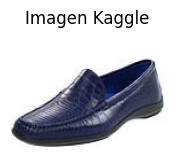

In [ ]:
# Seleccionamos una imagen aleatoria
clase = random.choice(os.listdir(carpeta))
fichero = random.choice(os.listdir(carpeta+clase))
# img_path = carpeta + clase + '/' + fichero # aleatorio
img_path = 'my_dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (3338).jpg'
imagen = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(2,2))
plt.imshow(imagen)
plt.title('Imagen Kaggle')
plt.axis('off')
plt.show()

In [ ]:
# Realizamos la predicción
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
top3 = decode_predictions(preds, top=3)[0]
# Mostramos predicción con probabilidad por clase
print('Top 3 predicciones:', top3)

1/1 [==============================] - 0s 188ms/step
Top 3 predicciones: [('n03680355', 'Loafer', 0.99713445), ('n03047690', 'clog', 0.0024401108), ('n04133789', 'sandal', 0.00022201565)]


In [ ]:
# Mostramos la clase que tiene la mayor probabilidad
pred_clase = top3[0][1]
pred_proba = top3[0][2]*100
print('Clase predicha: {}'.format(pred_clase))
print('Su probabilidad: {:.2f} %'.format(pred_proba))

Clase predicha: Loafer
Su probabilidad: 99.71 %


In [ ]:
%%capture
# Mostramos una imagen de ImageNet correspondiente a la calse predicha
# Para ello clonamos un repositorio que contiene imágenes de ImageNet
# https://github.com/EliSchwartz/imagenet-sample-images
!git clone https://github.com/EliSchwartz/imagenet-sample-images.git images

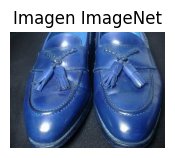

In [ ]:
# Cargamos la imagen correspondiente a la calse predicha
git_images = os.listdir('images')
git_image = [s for s in git_images if pred_clase.lower() in s.lower()][0]
imagen = cv2.imread('images/'+git_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(2,2))
plt.imshow(imagen)
plt.title('Imagen ImageNet')
plt.axis('off')
plt.show()

Antes de proceder con el Transfer Learning, volvemos a cargar los generadores, ya que las redes pre-entrenadas requieren imágenes cuadradas, con dimensiones por defecto de 224x224.

In [ ]:
# Volvemos a cargar los datos con rescale a 224x224
train_rescaled = image_dataset_from_directory('my_dataset/train',
                                    labels='inferred',
                                    label_mode='int',
                                    batch_size=batch_size,
                                    image_size=(224,224)   
                                    )

val_rescaled = image_dataset_from_directory('my_dataset/val',
                                  labels='inferred',
                                  label_mode='int',
                                  batch_size=batch_size,
                                  image_size=(224,224)   
                                  )

test_rescaled = image_dataset_from_directory('my_dataset/test',
                                    labels='inferred',
                                    label_mode='int',
                                    batch_size=batch_size,
                                    image_size=(224,224)   
                                    )

Found 12000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


## ResNet50
Ahora implementaremos nuestro propio Top Model con una salida adaptada a nuestro problema de 3 clases.

In [ ]:
# Cargamos Base Model de ResNet50
base_model_rn = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224,224,3))
base_model_rn.trainable = False

# Agregamos nuestro Top Model
model_rn = Sequential()
model_rn.add(base_model_rn)
model_rn.add(layers.Flatten())
model_rn.add(layers.Dense(32, activation='relu'))
model_rn.add(layers.Dense(16, activation='relu'))
model_rn.add(layers.Dense(3, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Compilamos y entrenamos el modelo
model_rn.compile(optimizer= 'adam', loss= 'SparseCategoricalCrossentropy', metrics=['accuracy'])

history_rn = model_rn.fit(train_rescaled,
                          validation_data=val_rescaled,
                          epochs=epochs)

Epoch 1/30
375/375 [==============================] - 49s 118ms/step - loss: 0.2188 - accuracy: 0.9597 - val_loss: 0.1201 - val_accuracy: 0.9813
Epoch 2/30
375/375 [==============================] - 42s 111ms/step - loss: 0.0435 - accuracy: 0.9900 - val_loss: 0.0833 - val_accuracy: 0.9847
Epoch 3/30
375/375 [==============================] - 42s 111ms/step - loss: 0.0160 - accuracy: 0.9952 - val_loss: 0.1245 - val_accuracy: 0.9820
Epoch 4/30
375/375 [==============================] - 42s 111ms/step - loss: 0.0203 - accuracy: 0.9949 - val_loss: 0.1010 - val_accuracy: 0.9867
Epoch 5/30
375/375 [==============================] - 42s 112ms/step - loss: 0.0094 - accuracy: 0.9972 - val_loss: 0.1566 - val_accuracy: 0.9827
Epoch 6/30
375/375 [==============================] - 42s 110ms/step - loss: 0.0186 - accuracy: 0.9952 - val_loss: 0.0825 - val_accuracy: 0.9893
Epoch 7/30
375/375 [==============================] - 41s 110ms/step - loss: 0.0434 - accuracy: 0.9906 - val_loss: 0.0635 - val_ac

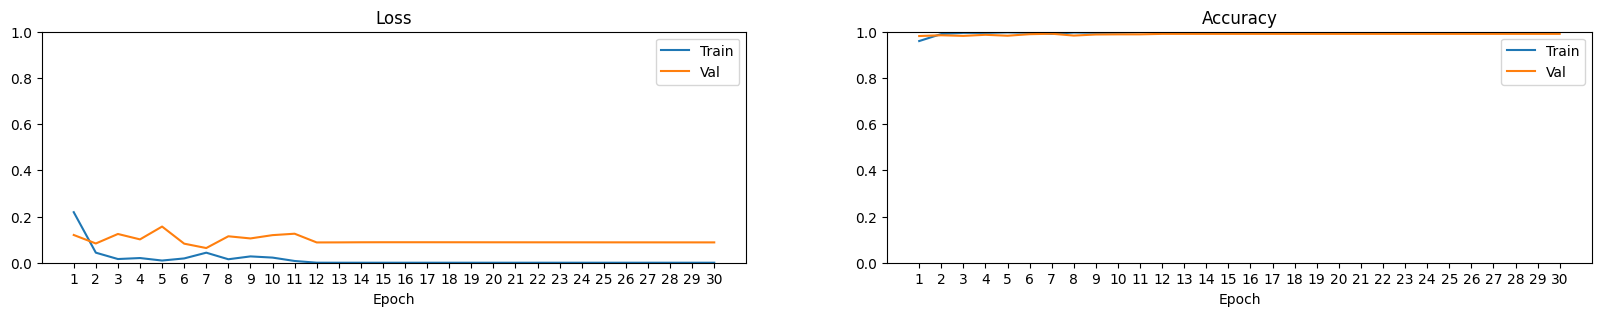

In [ ]:
#Visualizamos las curvas de pérdidas y de la métrica seleccionada
create_charts(history_rn)

Classification report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       500
           2       0.99      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500


Confusion Matrix:



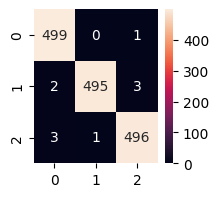

In [ ]:
# Evaluación sobre Test
y_test, y_pred = extraer_predicciones(model_rn, test_rescaled)
ver_resultados(y_test, y_pred)

Ahora aplicaremos regularización para reducir las pérdidas en validación. En base a pruebas realizadas, los mejores resultados se obtienen añadiendo capas de Dropout, pero sin BatchNormalization.

In [ ]:
# Cargamos Base Model de ResNet50
base_model_rn = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224,224,3))
base_model_rn.trainable = False

# Agregamos nuestro Top Model
model_rn = Sequential()
model_rn.add(base_model_rn)
model_rn.add(layers.Flatten())
model_rn.add(layers.Dense(32, activation='relu'))
model_rn.add(layers.Dropout(0.25))
model_rn.add(layers.Dense(16, activation='relu'))
model_rn.add(layers.Dropout(0.25))
model_rn.add(layers.Dense(3, activation='softmax'))

Hemos ocultado el entrenamiento del modelo para reducir el número de páginas del trabajo a entregar.

In [ ]:
# Compilamos y entrenamos el modelo
model_rn.compile(optimizer= 'adam', loss= 'SparseCategoricalCrossentropy', metrics=['accuracy'])

history_rn = model_rn.fit(train_rescaled, validation_data=val_rescaled, epochs=epochs)

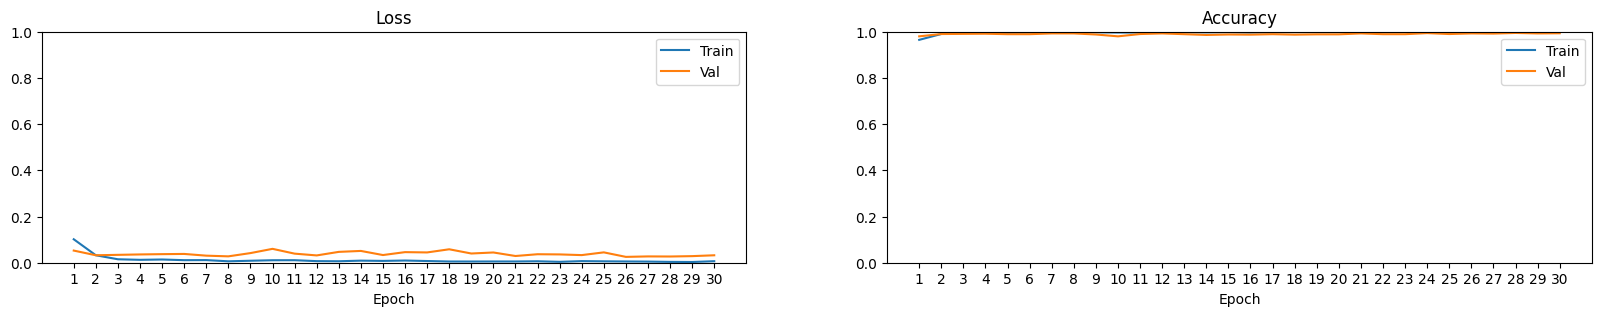

In [ ]:
#Visualizamos las curvas de pérdidas y de la métrica seleccionada
create_charts(history_rn)

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       500
           1       0.99      0.99      0.99       500
           2       0.99      0.99      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500


Confusion Matrix:



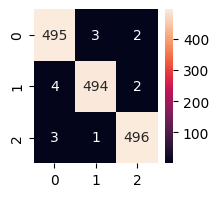

In [ ]:
# Evaluación sobre Test
y_test, y_pred = extraer_predicciones(model_rn, test_rescaled)
ver_resultados(y_test, y_pred)

Observamos que ResNet50, tanto sin la regularización como con ella, da un resultado sobre test de 99% accuracy. Si nos fijamos en precisión por clase del modelo antes de regularizar, observamos una presencia del 100%, por lo que los resultados sobre test del modelo sin regularizar son un poco mejores que del modelo regularizado.

## MobileNetV2

In [ ]:
# Cargamos Base Model de MobileNetV2
base_model_mn = MobileNetV2(weights='imagenet',
                            include_top=False,
                            input_shape=(224,224,3))
base_model_mn.trainable = False

# Agregamos nuestro Top Model
model_mn = Sequential()
model_mn.add(base_model_mn)
model_mn.add(layers.Flatten())
model_mn.add(layers.Dense(32, activation='relu'))
model_mn.add(layers.Dense(16, activation='relu'))
model_mn.add(layers.Dense(3, activation='softmax'))

# Compilamos y entrenamos el modelo
model_mn.compile(optimizer= 'adam', loss= 'SparseCategoricalCrossentropy', metrics=['accuracy'])

history_mn = model_mn.fit(train_rescaled, validation_data=val_rescaled, epochs=epochs)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/30
375/375 [==============================] - 26s 56ms/step - loss: 0.2478 - accuracy: 0.9209 - val_loss: 0.1162 - val_accuracy: 0.9600
Epoch 2/30
375/375 [==============================] - 20s 52ms/step - loss: 0.0711 - accuracy: 0.9759 - val_loss: 0.1007 - val_accuracy: 0.9687
Epoch 3/30
375/375 [==============================] - 20s 53ms/step - loss: 0.0333 - accuracy: 0.9893 - val_loss: 0.0890 - val_accuracy: 0.9760
Epoch 4/30
375/375 [==============================] - 20s 52ms/step - loss: 0.0178 - accuracy: 0.9942 - val_loss: 0.1941 - val_accuracy: 0.9513
Epoch 5/30
375/375 [==============================] - 20s 52ms/step - loss: 0.0234 - accuracy: 0.9913 - val_loss: 0.0977 - val_accuracy: 0.9727
Epoch 6/30
375/375 [==============================] - 20s 52ms/step - loss: 0.0335 - accuracy: 0.9892 - val_loss: 0.0977 - val_accuracy: 0.9780
Epoch 7/30
375/375 [==============================] - 20s 53ms/step - los

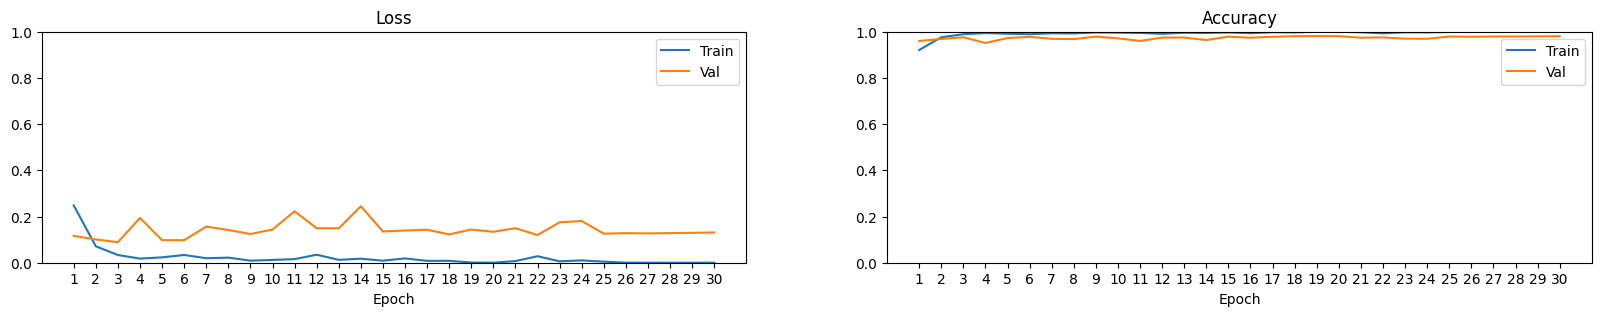

In [ ]:
#Visualizamos las curvas de pérdidas y de la métrica seleccionada
create_charts(history_mn)

Observamos overfitting, la red literalmente se aprendió todas las muestras del train ya que muestra una precisión del 100%. Veamos la evaluación sobre Test, y posteriormente aplicaremos los métodos de regularización para reducir overfitting y ver si podemos mejorar resultados sobre Test.

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.97      0.95      0.96       500
           2       0.95      0.97      0.96       500

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500


Confusion Matrix:



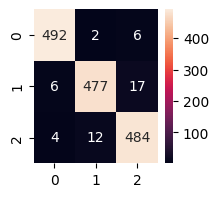

In [ ]:
# Evaluación sobre Test
y_test, y_pred = extraer_predicciones(model_mn, test_rescaled)
ver_resultados(y_test, y_pred)

Agregamos la regularización para paliar overfitting:

In [ ]:
model_mn_reg = Sequential()
model_mn_reg.add(base_model_mn)
model_mn_reg.add(layers.Flatten())
model_mn_reg.add(layers.Dense(32, activation='relu'))
model_mn_reg.add(layers.Dropout(0.25))
model_mn_reg.add(layers.Dense(16, activation='relu'))
model_mn_reg.add(layers.Dropout(0.25))
model_mn_reg.add(layers.Dense(3, activation='softmax'))

model_mn_reg.compile(optimizer= 'adam', loss= 'SparseCategoricalCrossentropy', metrics=['accuracy'])

history_mn_reg = model_mn_reg.fit(train_rescaled, validation_data=val_rescaled, epochs=epochs)

Hemos ocultado el entrenamiento del modelo para reducir el número de páginas del trabajo a entregar.

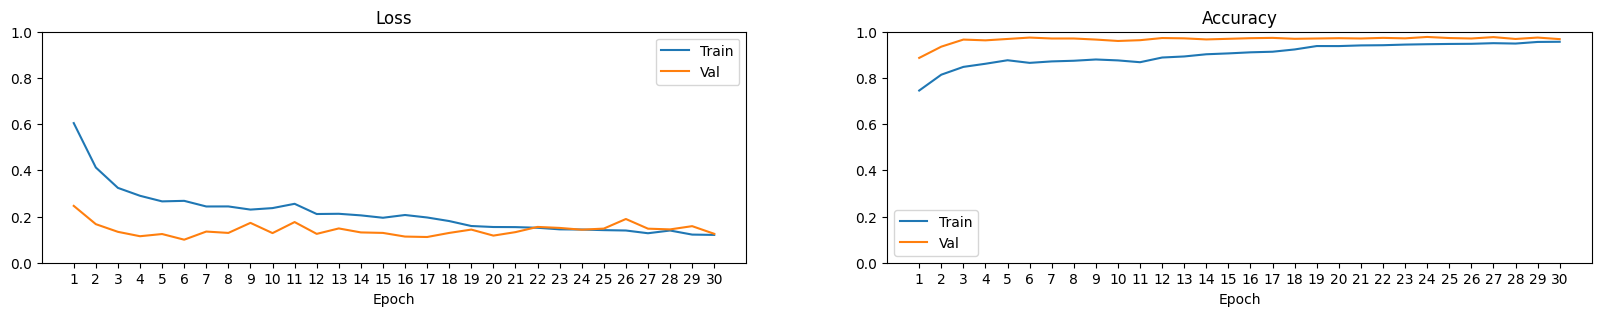

In [ ]:
#Visualizamos las curvas de pérdidas y de la métrica seleccionada
create_charts(history_mn_reg)

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       500
           1       0.97      0.92      0.95       500
           2       0.92      0.97      0.95       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500


Confusion Matrix:



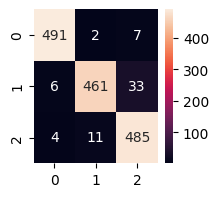

In [ ]:
# Evaluación sobre Test
y_test, y_pred = extraer_predicciones(model_mn_reg, test_rescaled)
ver_resultados(y_test, y_pred)

Observamos que la regularización reduce el efecto de overfitting, pero no mejora el resultado agregado sobre el Test.

## Conclusiones red pre-entrenada

Después de entrenar ambas arquitecturas elegidas, hemos podido comprobar que los resultados obtenidos son muy buenos en ambos casos. ResNet50 da un resultado superior al 99% de accuracy sobre el Test, mientras que MobileNetV2 muestra alrededor de 97%. ResNet50 sería nuestra elección debido a mejores resultados, pero cabe mencionar que considerando lo ligera que es MobileNetV2 tanto en su tamaño en MB como en número de parámetros, ha proporcionado unos resultados excelentes.

# Conclusiones finales
Primero hemos diseñado nuestro propio modelo desde cero y hemos probado diferentes arquitecturas, eligiendo la mejor. Para eliminar el overfitting, hemos aplicado diferentes técnicas como Data Augmentation, Batch Normalization y Dropout. Posteriormente hemos aplicado Keras Tuner para escoger la mejor combinación de los hiperparametros. Y aún así no hemos podido superar los resultados que da un modelo pre-entrenado sobre el conjunto de imagenes ImageNet.

Transfer Learning ha demostrado su gran potencial y la facilidad de implementación. Tan solo reemplazando su Top Model, incluso sin regularización se obtienen resultados superiores al 99% sobre el Test! Estamos convencid@s que afinando la arquitectura y los hiperparametros del Top Model, incluso sin la necesidad de desongelar las capas del Base Model, se podría mejorar los resultados aún más.

Por ello, el modelo que proporciona los mejores resultados sobre nuestro dataset es ResNet50.